## Prediction of metal ion content from multi-parameter data


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import math

First I read in the data. It is a multi-parameter dataset consisting of 201 samples obtained from 67 mixtures of Cadmium, Lead, and tap water.  Three features (attributes) were measured for each sample (Mod1, Mod2, Mod3).

The task is to use K-Nearest Neighbor Regression to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), for each sample using number of neighbors k = 1, 2, 3, 4 and 5. 

In [3]:
df=pd.read_csv('Dataset.csv')
print(df.head())
df.shape

   c_total   Cd    Pb   Mod1  Mod2    Mod3
0        0  0.0   0.0   9945   119   72335
1        0  0.0   0.0  10786   117   82977
2        0  0.0   0.0  10812   120   98594
3       14  0.0  14.0   9742   127  154323
4       14  0.0  14.0  10566   108  136416


(201, 6)

In [4]:
df.describe()

,c_total,Cd,Pb,Mod1,Mod2,Mod3
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,804.985075,402.492537,402.492537,104667.039801,7882.034826,92799.567164
std,1441.037444,915.092372,915.092372,97722.036782,11618.700600,61226.844509
min,0.000000,0.000000,0.000000,7919.000000,101.000000,2153.000000
25%,35.000000,8.000000,8.000000,20515.000000,317.000000,24312.000000
50%,100.000000,40.000000,40.000000,55911.000000,2708.000000,107854.000000
75%,1000.000000,300.000000,300.000000,174644.000000,8047.000000,143333.000000
max,5000.000000,5000.000000,5000.000000,304601.000000,42466.000000,210270.000000


As we can see, Mod1, Mod2 and Mod3 have different scales. Because I will use K-Nearest Neighbors Regression, which utilizes distances between input data points, I have to normalize them (x). I use z-score to normalize x.

In [5]:
from scipy.stats import zscore
x=df.loc[:, 'Mod1':'Mod3']
x=x.values
X=zscore(x, axis=0)
X.shape

(201, 3)

In [7]:
y_total= df.loc[:,'c_total']
y_total=y_total.values

In [6]:
y_Cd= df.loc[:,'Cd']
y_Cd=y_Cd.values

In [7]:
y_Pb= df.loc[:,'Pb']
y_Pb=y_Pb.values

## C-index
I will estimate model performance by calculating C-index, which indicates how well the model captures the relative ordering/ranking of the data points. Thus I need a function for calculating C-index.

In [8]:
def cIndex(y_true, y_predicted):
    n=0
    h_sum=0
    for i in range(len(y_true)):
        t=y_true[i]
        p=y_predicted[i]
        for j in range((i+1), len(y_true)):
            nt=y_true[j]
            np=y_predicted[j] 
            if (t != nt):
                n=n+1
                if (t < nt and p < np) or (t > nt and p > np):
                    h_sum = h_sum+1
                elif (p==np):
                    h_sum = h_sum + 0.5
    return h_sum/n  

Test:

In [9]:
y_true = [-1, 1, 1, -1, 1]
y_predicted = [0.60, 0.80, 0.75, 0.75, 0.70]
cIndex(y_true, y_predicted)


0.75

## Leave-One-Out Cross Validation approach
I start with K-Nearest Neighbors Regression from the Scikit-learn library using Euclidean distance.

In [10]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsRegressor
loo = LeaveOneOut()


def loo_sk_knn(X,y,k):
    y_predicted= np.zeros(len(y))
    for train_index, test_index in loo.split(X):
        X_train=X[train_index]
        y_train=y[train_index] 
        X_test=X[test_index]
        y_test=y[test_index]
        knn = KNeighborsRegressor(k)
        knn.fit(X_train,y_train)
        y_predicted[test_index] = knn.predict(X_test)
    C_index= cIndex(y, y_predicted)
    print('k =',k,': C-index =', C_index)
    return C_index


Next I will do my own implementation of K-Nearest Neighbors Regression.

In [11]:
# the function to calculate distance
def euclideanDistance(x1,x2):   
    return np.sqrt(np.sum((x1-x2)**2))

# the function that returns k most similar neighbors from the training set for a given test instance
import operator
def getNeighbors(X_train, X_test, k):
    distances = []
    for i in range(len(X_train)):
        dist = euclideanDistance(X_test, X_train[i])
        distances.append((X_train[i], dist, i))
    distances.sort(key=operator.itemgetter(1))
    neighbors_ind = []
    for x in range(k):
        neighbors_ind.append(distances[x][2])
    return neighbors_ind

# the function which calculates the mean value of k nearest neighbours
def knnPredictRegression(neighbors_ind, y_train):
    response = 0
    for i in range(len(neighbors_ind)):
        response += y_train[neighbors_ind[i]]      
    return (response/len(neighbors_ind))

# my own implementation of K-Nearest Neighbours Regression with Leave-One-Out Cross Validation
def loo_own_knn(X,y,k):
    y_predicted= np.zeros(len(y))
    for train_index, test_index in loo.split(X):
        X_train=X[train_index]
        y_train=y[train_index] 
        X_test=X[test_index]
        y_test=y[test_index]
        neighbors_ind = getNeighbors(X_train, X_test, k)
        y_predicted[test_index] = knnPredictRegression(neighbors_ind, y_train)
    C_index= cIndex(y, y_predicted)
    print('k =',k,': C-index =', C_index)
    return C_index

Testing, that my own implementation of KNN-Regression gives the same values than the one from the Scikit-learn library.

In [12]:
for k in range(1,6):
    c=loo_sk_knn(X,y_total,k)
    c=loo_own_knn(X,y_total,k)

k = 1 : C-index = 0.8986640599543826
k = 1 : C-index = 0.8986640599543826
k = 2 : C-index = 0.9056152927120669
k = 2 : C-index = 0.9056152927120669
k = 3 : C-index = 0.9036059519930487
k = 3 : C-index = 0.9036059519930487
k = 4 : C-index = 0.8919572064733355
k = 4 : C-index = 0.8919572064733355
k = 5 : C-index = 0.8804170739654611
k = 5 : C-index = 0.8804170739654611


Nice, I will continue with my own implementation only.

k = 1 : C-index = 0.8986640599543826
k = 2 : C-index = 0.9056152927120669
k = 3 : C-index = 0.9036059519930487
k = 4 : C-index = 0.8919572064733355
k = 5 : C-index = 0.8804170739654611


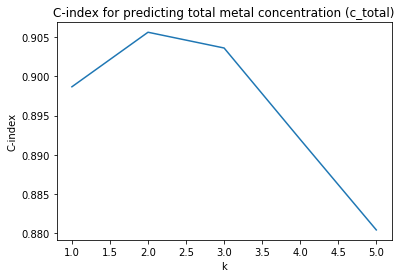

The best C-index achieved:  0.9056152927120669 , with k =  2


In [13]:
C_k = []
for k in range(1,6):
    c=loo_own_knn(X,y_total,k)
    C_k.append(c)

k = np.arange(1 , 6)
plt.plot(k, C_k )
plt.title('C-index for predicting total metal concentration (c_total)')
plt.ylabel('C-index')
plt.xlabel('k')
plt.show()

print('The best C-index achieved: ',max(C_k), ', with k = ', (np.argmax(C_k)+1 ))

k = 1 : C-index = 0.9005806654111739
k = 2 : C-index = 0.9026208411801632
k = 3 : C-index = 0.87769407825905
k = 4 : C-index = 0.8515902908558276
k = 5 : C-index = 0.8254080351537979


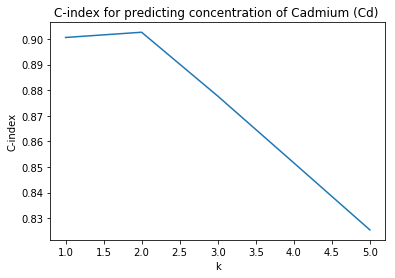

The best C-index achieved:  0.9026208411801632 , with k =  2


In [14]:
C_k = []
for k in range(1,6):
    c=loo_own_knn(X,y_Cd,k)
    C_k.append(c)

k = np.arange(1 , 6)
plt.plot(k, C_k )
plt.title('C-index for predicting concentration of Cadmium (Cd) ')
plt.ylabel('C-index')
plt.xlabel('k')
plt.show()

print('The best C-index achieved: ',max(C_k), ', with k = ', (np.argmax(C_k)+1 ))


k = 1 : C-index = 0.866368487131199
k = 2 : C-index = 0.8723843900397573
k = 3 : C-index = 0.849471646788031
k = 4 : C-index = 0.8450774220548232
k = 5 : C-index = 0.8303515379786566


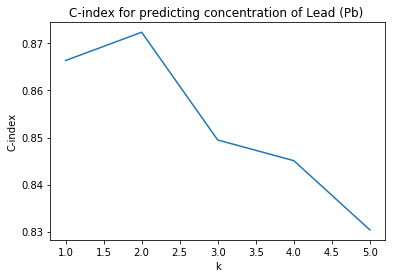

The best C-index achieved:  0.8723843900397573 , with k =  2


In [15]:
C_k = []
for k in range(1,6):
    c=loo_own_knn(X,y_Pb,k)
    C_k.append(c)

k = np.arange(1 , 6)
plt.plot(k, C_k )
plt.title('C-index for predicting concentration of Lead (Pb) ')
plt.ylabel('C-index')
plt.xlabel('k')
plt.show()

print('The best C-index achieved: ',max(C_k), ', with k = ', (np.argmax(C_k)+1 ))

For all predicted y, C-index was the best with k = 2. This was just what was expected, because in the test set there were 3 replicas measured from each mixture.

The best C-indices:
* total metal concentration (c_total): 0.91
* concentration of Cadmium (Cd): 0.90
* concentration of Lead (Pb): 0.87



## Leave-Three-Out Cross Validation approach

This time I need a function to divide the data into folds.

In [16]:
def partition(n, LeaveOut):
    folds = []
    S = set(range(n))
    for i in list(S)[0:len(S):LeaveOut]:
        fold = set()
        fold.add(i)
        fold.add(i+1)
        fold.add(i+2)
        folds.append(fold)
    return folds, S

In [17]:
folds, S = partition(201,3)

Again, I start with K-Nearest Neighbors Regression from the Scikit-learn library using Euclidean distance.

In [18]:
def l3o_sk_knn(X,y,folds,S,k):
    y_predicted= np.zeros(len(y))
    for n in range(len(folds)):
        X_train=X[list(S-folds[n])]
        y_train=y[list(S-folds[n])] 
        X_test=X[list(folds[n])]
        y_test=y[list(folds[n])]
        knn = KNeighborsRegressor(k)
        knn.fit(X_train,y_train)
        y_p= knn.predict(X_test)
        y_predicted[n*3]=y_p[0]
        y_predicted[n*3 + 1]=y_p[1]
        y_predicted[n*3 + 2]=y_p[2]
    C_index = cIndex(y, y_predicted)
    print('k =',k,': C-index =', C_index)
    return C_index

And then my own implementation of K-Nearest Neighbors Regression with Leave-Three-Out Cross Validation.

In [19]:
def l3o_own_knn(X,y,folds, S, k):
    y_predicted= np.zeros(len(y))
    for n in range(len(folds)):
        X_train=X[list(S-folds[n])]
        y_train=y[list(S-folds[n])] 
        X_test=X[list(folds[n])]
        y_test=y[list(folds[n])]
        for i in range(len(X_test)):
            neighbors_ind = getNeighbors(X_train, X_test[i], k)
            y_predicted[n*3 + i] = knnPredictRegression(neighbors_ind, y_train)
    C_index= cIndex(y, y_predicted)
    print('k =',k,': C-index =', C_index)
    return C_index

Testing, that my own implementation of KNN-Regression gives the same values than the one in the Scikit-learn library.

In [20]:
for k in range(1,6):
    c=l3o_sk_knn(X,y_total,folds,S,k)
    c=l3o_own_knn(X,y_total,folds,S,k)

k = 1 : C-index = 0.8150048875855328
k = 1 : C-index = 0.8150048875855328
k = 2 : C-index = 0.8157380254154448
k = 2 : C-index = 0.8157380254154448
k = 3 : C-index = 0.8200553926360378
k = 3 : C-index = 0.8200553926360378
k = 4 : C-index = 0.8226892581731291
k = 4 : C-index = 0.8226892581731291
k = 5 : C-index = 0.815167807103291
k = 5 : C-index = 0.815167807103291


 Both functions give the same answers, so I can continue with my own implementation only.

k = 1 : C-index = 0.8150048875855328
k = 2 : C-index = 0.8157380254154448
k = 3 : C-index = 0.8200553926360378
k = 4 : C-index = 0.8226892581731291
k = 5 : C-index = 0.815167807103291


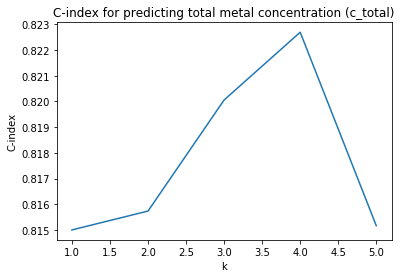

The best C-index achieved:  0.8226892581731291 , with k =  4


In [22]:
C_k = []
for k in range(1,6):
    c=l3o_own_knn(X,y_total,folds, S, k)
    C_k.append(c)

k = np.arange(1 , 6)
plt.plot(k, C_k )
plt.title('C-index for predicting total metal concentration (c_total)')
plt.ylabel('C-index')
plt.xlabel('k')
plt.show()

print('The best C-index achieved: ',max(C_k), ', with k = ', (np.argmax(C_k)+1 ))

k = 1 : C-index = 0.7410284578363674
k = 2 : C-index = 0.7455011508683825
k = 3 : C-index = 0.7353525842226407
k = 4 : C-index = 0.7221437539234149
k = 5 : C-index = 0.7206528562460766


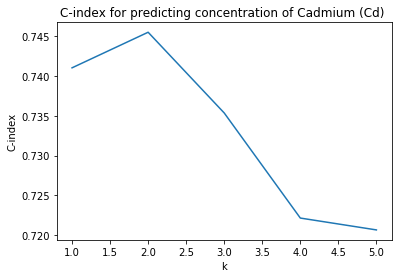

The best C-index achieved:  0.7455011508683825 , with k =  2


In [23]:
C_k = []
for k in range(1,6):
    c=l3o_own_knn(X,y_Cd,folds, S, k)
    C_k.append(c)

k = np.arange(1 , 6)
plt.plot(k, C_k )
plt.title('C-index for predicting concentration of Cadmium (Cd) ')
plt.ylabel('C-index')
plt.xlabel('k')
plt.show()

print('The best C-index achieved: ',max(C_k), ', with k = ', (np.argmax(C_k)+1 ))


k = 1 : C-index = 0.7362680477087257
k = 2 : C-index = 0.7518832391713748
k = 3 : C-index = 0.7527463904582549
k = 4 : C-index = 0.7594423519564762
k = 5 : C-index = 0.755937434609751


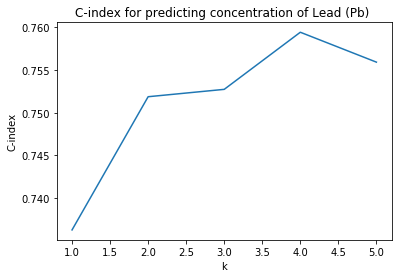

The best C-index achieved:  0.7594423519564762 , with k =  4


In [24]:
C_k = []
for k in range(1,6):
    c=l3o_own_knn(X,y_Pb,folds, S, k)
    C_k.append(c)

k = np.arange(1 , 6)
plt.plot(k, C_k )
plt.title('C-index for predicting concentration of Lead (Pb) ')
plt.ylabel('C-index')
plt.xlabel('k')
plt.show()

print('The best C-index achieved: ',max(C_k), ', with k = ', (np.argmax(C_k)+1 ))

The best C-index achieved:  
* for predicting total metal concentration (c_total): 0.82 , with k =  4
* for predicting concentration of Cadmium (Cd): 0.75 , with k =  2
* for predicting concentration of Lead (Pb): 0.76 , with k =  4

These evaluations are lower than with Leave-One-Out Cross Validation. Leave-Three-Out Cross Validation evaluation approach generalize better because then no replicas of the same mixture can be used in training and prediction.